In [ ]:
%pip install brian2
%pip install brian2tools
%pip install scipy
!pip install --upgrade scipy

Requirement already up-to-date: scipy in /usr/local/lib/python3.7/dist-packages (1.6.3)


In [ ]:
from brian2 import *
from brian2tools import *
import numpy as np
import pandas as pd
from scipy import io
from scipy import sparse
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/MyDrive/Figures_Package')
import seaborn as sns

Mounted at /content/gdrive


In [ ]:
initial_v = np.load('/content/gdrive/MyDrive/Figures_Package/Networks/initial_voltage.npy')

In [ ]:
w_EE = sparse.load_npz('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/w_EE6.npz')
w_IE = sparse.load_npz('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/w_IE_sparse.npz')
w_EI = sparse.load_npz('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/w_EI_sparse.npz')
w_II = sparse.load_npz('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/w_II_sparse.npz')

In [ ]:
j_EE, i_EE, w_EE = sparse.find(w_EE)
j_IE, i_IE, w_IE = sparse.find(w_IE)
j_EI, i_EI, w_EI = sparse.find(w_EI)
j_II, i_II, w_II = sparse.find(w_II)

In [ ]:
#define network parameters

#total size of the network
N = 40000

#threshold, reset and refractory parameters
v_theta = 33*mV
v_reset = 24.75*mV
tau_ref = 1*ms
v_0 = -1000*mV

#indices that delimit inhibitory and excitatory populations 20/80
first_inh = 0
last_inh = int(0.2*N)
first_exc = last_inh
last_exc = N


#these are additional parameters to play with resizing of weights (in paper would be 1)
g_E = 1
g_I = 1


#External drive to each population

H_in = 57.8*mV
H_ex = 77.6*mV

tau_in = np.log((H_in - v_reset)/(H_in - v_theta))*second;
tau_ex = np.log((H_ex - v_reset)/(H_ex - v_theta))*second;


#clear brian scope to reset any past variables
start_scope()

#define the model that each neuron will follow
tau = 10*ms
eqs = '''
dv/dt = -(v - H_ext)/tau : volt (unless refractory)
H_ext : volt
'''

#the original network is defined
all_neurons = NeuronGroup(N, eqs, threshold = 'v>v_theta', reset = 'v=v_reset', refractory = tau_ref, method = 'exact')

#to work with subpopulations bria-n uses slicing notation
in_neurons = all_neurons[first_inh:last_inh]
ex_neurons = all_neurons[first_exc:last_exc]
#targ_neurons = ex_neurons[:6400]

all_neurons.v = initial_v*mV

#define external drive according to supp table 1
in_neurons.H_ext = H_in
ex_neurons.H_ext = H_ex


#initialize the synaptic object for the different subpopulation pairs
S_EE = Synapses(ex_neurons, ex_neurons, 'w : volt', on_pre ='v += w')
S_IE = Synapses(ex_neurons, in_neurons, 'w : volt', on_pre ='v += w')
S_EI = Synapses(in_neurons, ex_neurons,'w : volt', on_pre ='v -= w')
S_II = Synapses(in_neurons, in_neurons, 'w : volt', on_pre ='v -= w')

#initialize the synaptic object for the different subpopulation pairs
#connect them according to probabilities in supp table 1
S_EE.connect(i=i_EE, j=j_EE)
S_IE.connect(i=i_IE, j=j_IE)
S_EI.connect(i=i_EI, j=j_EI)
S_II.connect(i=i_II, j=j_II)

S_EE.w = w_EE*mV
S_IE.w = w_IE*volt
S_EI.w = w_EI*volt
S_II.w = w_II*volt


#monitors spiking events
M_in = SpikeMonitor(in_neurons)
M_ex = SpikeMonitor(ex_neurons)

In [ ]:
#N_E = 32000
#N_I = 8000
#super_path = '/content/gdrive/MyDrive/Figures_Package/Session_Matrices/'

#w_IE = zeros((N_I, N_E))
#w_IE[S_IE.j, S_IE.i] = S_IE.w
#w_IE = sparse.csc_matrix(w_IE)
#path_IE = super_path + 'w_IE_sparse.npz'
#sparse.save_npz(path_IE, w_IE)

#w_EI = zeros((N_E, N_I))
#w_EI[S_EI.j, S_EI.i] = S_EI.w
#w_EI = sparse.csc_matrix(w_EI)
#path_EI = super_path + 'w_EI_sparse.npz'
#sparse.save_npz(path_EI, w_EI)
#w_II = zeros((N_I, N_I))

#w_II[S_II.j, S_II.i] = S_II.w
#w_II = sparse.csc_matrix(w_II)
#sparse.save_npz(path_II, w_II)
#path_II = super_path + 'w_II_sparse.npz'

In [ ]:
defaultclock.dt = 0.005*ms
total_time = 10000*ms

run(total_time, report = 'text')

Starting simulation at t=0. s for a duration of 10. s
144.22 ms (1%) simulated in 10s, estimated 11m 23s remaining.
295.965 ms (2%) simulated in 20s, estimated 10m 56s remaining.
0.45381 s (4%) simulated in 30s, estimated 10m 31s remaining.
0.62679 s (6%) simulated in 40s, estimated 9m 58s remaining.
0.801695 s (8%) simulated in 50s, estimated 9m 34s remaining.
0.97662 s (9%) simulated in 1m 0s, estimated 9m 14s remaining.
1.14974 s (11%) simulated in 1m 10s, estimated 8m 59s remaining.
1.326235 s (13%) simulated in 1m 20s, estimated 8m 43s remaining.
1.50277 s (15%) simulated in 1m 30s, estimated 8m 29s remaining.
1.680175 s (16%) simulated in 1m 40s, estimated 8m 15s remaining.
1.859735 s (18%) simulated in 1m 50s, estimated 8m 1s remaining.
2.039045 s (20%) simulated in 2m 0s, estimated 7m 49s remaining.
2.217315 s (22%) simulated in 2m 10s, estimated 7m 36s remaining.
2.396885 s (23%) simulated in 2m 20s, estimated 7m 24s remaining.
2.57534 s (25%) simulated in 2m 30s, estimated 7m

In [ ]:
def process_firings(M_in, M_ex, time):
    global session
    count_in = np.array(M_in.count)/(time/second)
    count_ex = np.array(M_ex.count)/(time/second)
    count_in_path = '/content/gdrive/MyDrive/Figures_Package/Session_Matrices/FR_in_session' + str(session) + '.npy'
    count_ex_path = '/content/gdrive/MyDrive/Figures_Package/Session_Matrices/FR_ex_session' + str(session) + '.npy'
    np.save(count_in_path, count_in)
    np.save(count_ex_path, count_ex)

In [ ]:
time=total_time
session = 6
process_firings(M_in, M_ex, time)

In [ ]:
FR_ex_1 = np.load('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/FR_ex_session1.npy')
FR_in_1 = np.load('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/FR_in_session1.npy')
FR_ex_2 = np.load('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/FR_ex_session2.npy')
FR_in_2 = np.load('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/FR_in_session2.npy')
FR_ex_3 = np.load('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/FR_ex_session3.npy')
FR_in_3 = np.load('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/FR_in_session3.npy')
FR_ex_4 = np.load('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/FR_ex_session4.npy')
FR_in_4 = np.load('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/FR_in_session4.npy')
FR_ex_5 = np.load('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/FR_ex_session5.npy')
FR_in_5 = np.load('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/FR_in_session5.npy')
FR_ex_6 = np.load('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/FR_ex_session6.npy')
FR_in_6 = np.load('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/FR_in_session6.npy')

In [ ]:
N_E = 32000
N_I = 8000
FR_in_1_plot = FR_in_1[1:20]
FR_ex_1_plot = FR_ex_1[1:20]
FR_in_2_plot = FR_in_2[1:20]
FR_ex_2_plot = FR_ex_2[1:20]
FR_in_3_plot = FR_in_3[1:20]
FR_ex_3_plot = FR_ex_3[1:20]
FR_in_4_plot = FR_in_4[1:20]
FR_ex_4_plot = FR_ex_4[1:20]
FR_in_5_plot = FR_in_5[1:20]
FR_ex_5_plot = FR_ex_5[1:20]
FR_in_6_plot = FR_in_6[1:20]
FR_ex_6_plot = FR_ex_6[1:20]

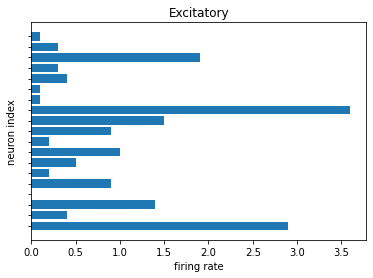

In [ ]:
import matplotlib.pyplot as pllt
x_pos = np.arange(len(FR_ex_1_plot))
plt.barh(x_pos,FR_ex_1_plot, align='center')
ylabel('neuron index')
xlabel('firing rate')
title('Excitatory')

# Turn off tick labels
plt.yticks(x_pos, " ")
plt.show()

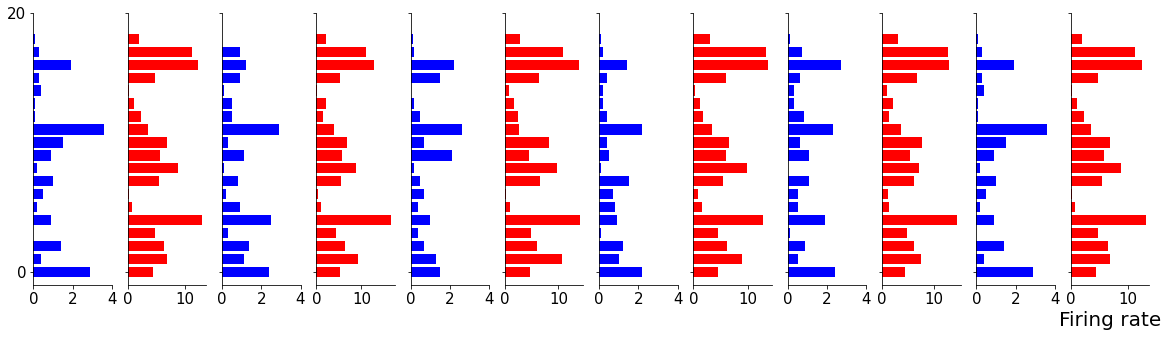

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12) = plt.subplots(ncols=12,figsize=(20,5),sharey=True)

x_pos1 = np.arange(len(FR_ex_1_plot))
ax1.barh(x_pos1, FR_ex_1_plot, color = "blue")
ax1.set_xticks(np.arange(0, 5, 2))
ax1.set_yticks(np.arange(0, 21, 20))
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
#ax1.set_xticklabels(x_pos1, fontsize=8)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)

x_pos2 = np.arange(len(FR_in_1_plot))
ax2.barh(x_pos2, FR_in_1_plot, color = "r")
ax2.set_xticks(np.arange(0, 20, 10))
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.tick_params(axis='x', labelsize=15)

x_pos3 = np.arange(len(FR_ex_2_plot))
ax3.barh(x_pos3, FR_ex_2_plot, color = "b")
ax3.set_xticks(np.arange(0, 5, 2))
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.tick_params(axis='x', labelsize=15)

x_pos4 = np.arange(len(FR_in_2_plot))
ax4.barh(x_pos4, FR_in_2_plot, color = "r")
ax4.set_xticks(np.arange(0, 20, 10))
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
ax4.tick_params(axis='x', labelsize=15)

x_pos5 = np.arange(len(FR_ex_3_plot))
ax5.barh(x_pos5, FR_ex_3_plot, color = "b")
ax5.set_xticks(np.arange(0, 5, 2))
ax5.spines["top"].set_visible(False)
ax5.spines["right"].set_visible(False)
ax5.tick_params(axis='x', labelsize=15)

x_pos6 = np.arange(len(FR_in_3_plot))
ax6.barh(x_pos6, FR_in_3_plot, color = "r")
ax6.set_xticks(np.arange(0, 20, 10))
ax6.spines["top"].set_visible(False)
ax6.spines["right"].set_visible(False)
ax6.tick_params(axis='x', labelsize=15)

x_pos7 = np.arange(len(FR_ex_4_plot))
ax7.barh(x_pos7, FR_ex_4_plot, color = "b")
ax7.set_xticks(np.arange(0, 5, 2))
ax7.spines["top"].set_visible(False)
ax7.spines["right"].set_visible(False)
ax7.tick_params(axis='x', labelsize=15)

x_pos8 = np.arange(len(FR_in_4_plot))
ax8.barh(x_pos8, FR_in_4_plot, color = "r")
ax8.set_xticks(np.arange(0, 20, 10))
ax8.spines["top"].set_visible(False)
ax8.spines["right"].set_visible(False)
ax8.tick_params(axis='x', labelsize=15)

x_pos9 = np.arange(len(FR_ex_5_plot))
ax9.barh(x_pos9, FR_ex_5_plot, color = "b")
ax9.set_xticks(np.arange(0, 5, 2))
ax9.spines["top"].set_visible(False)
ax9.spines["right"].set_visible(False)
ax9.tick_params(axis='x', labelsize=15)

x_pos10 = np.arange(len(FR_in_5_plot))
ax10.barh(x_pos10, FR_in_5_plot, color = "r")
ax10.set_xticks(np.arange(0, 20, 10))
ax10.spines["top"].set_visible(False)
ax10.spines["right"].set_visible(False)
ax10.tick_params(axis='x', labelsize=15)

x_pos11 = np.arange(len(FR_ex_6_plot))
ax11.barh(x_pos11, FR_ex_6_plot, color = "b")
ax11.set_xticks(np.arange(0, 5, 2))
ax11.spines["top"].set_visible(False)
ax11.spines["right"].set_visible(False)
ax11.tick_params(axis='x', labelsize=15)

x_pos12 = np.arange(len(FR_in_6_plot))
ax12.barh(x_pos12, FR_in_6_plot, color = "r")
ax12.set_xticks(np.arange(0, 20, 10))
ax12.spines["top"].set_visible(False)
ax12.spines["right"].set_visible(False)
ax12.tick_params(axis='x', labelsize=15)

plt.xlabel('Firing rate', fontsize=20)
plt.ylim(ymin=-1, ymax = 20)
plt.savefig('/content/gdrive/MyDrive/Figures_Package/Figures/figure2B_bottom_NEW.png',
            dpi=300, bbox_inches = 'tight')

WARNING    /usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 [py.warnings]
  warnings.warn(msg, FutureWarning)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


(0.0, 10.0)

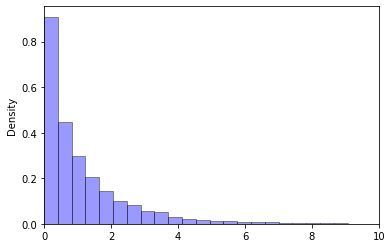

In [ ]:
sns.distplot(FR_ex_2, hist=True, kde=True,
bins=50, color = 'blue',
hist_kws={'edgecolor':'black'},
kde_kws={'linewidth': 0})
plt.xlim(xmin=0, xmax = 10)

WARNING    /usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 [py.warnings]
  warnings.warn(msg, FutureWarning)



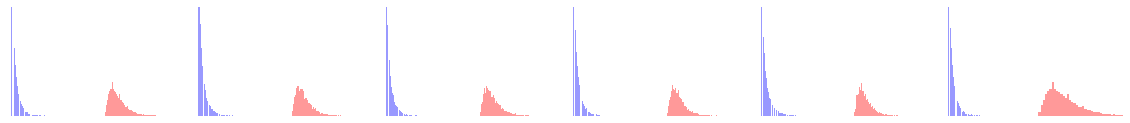

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12) = plt.subplots(ncols=12,sharey=True, figsize=(20,2))
fig.subplots_adjust(wspace=0.1)

sns.distplot(FR_ex_1, ax=ax1, bins='auto', hist=True, kde=False, color = "b")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.axis('off')

sns.distplot(FR_in_1, ax=ax2, bins='auto', hist=True, kde=False, color = "r")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.axis('off')

sns.distplot(FR_ex_2, ax=ax3, bins='auto', hist=True, kde=False, color = "b")
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)
ax3.spines["left"].set_visible(False)
ax3.axis('off')

sns.distplot(FR_in_2, ax=ax4, bins='auto', hist=True, kde=False, color = "r")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
ax4.spines["bottom"].set_visible(False)
ax4.spines["left"].set_visible(False)
ax4.axis('off')

sns.distplot(FR_ex_3, ax=ax5, bins='auto', hist=True, kde=False, color = "b")
ax5.spines["top"].set_visible(False)
ax5.spines["right"].set_visible(False)
ax5.spines["bottom"].set_visible(False)
ax5.spines["left"].set_visible(False)
ax5.axis('off')

sns.distplot(FR_in_3, ax=ax6, bins='auto', hist=True, kde=False, color = "r")
ax6.spines["top"].set_visible(False)
ax6.spines["right"].set_visible(False)
ax6.spines["bottom"].set_visible(False)
ax6.spines["left"].set_visible(False)
ax6.axis('off')

sns.distplot(FR_ex_4, ax=ax7, bins='auto', hist=True, kde=False, color = "b")
ax7.spines["top"].set_visible(False)
ax7.spines["right"].set_visible(False)
ax7.spines["bottom"].set_visible(False)
ax7.spines["left"].set_visible(False)
ax7.axis('off')

sns.distplot(FR_in_4, ax=ax8, bins='auto', hist=True, kde=False, color = "r")
ax8.spines["top"].set_visible(False)
ax8.spines["right"].set_visible(False)
ax8.spines["bottom"].set_visible(False)
ax8.spines["left"].set_visible(False)
ax8.axis('off')

sns.distplot(FR_ex_5, ax=ax9, bins='auto', hist=True, kde=False, color = "b")
ax9.spines["top"].set_visible(False)
ax9.spines["right"].set_visible(False)
ax9.spines["bottom"].set_visible(False)
ax9.spines["left"].set_visible(False)
ax9.axis('off')

sns.distplot(FR_in_5, ax=ax10, bins='auto', hist=True, kde=False, color = "r")
ax10.spines["top"].set_visible(False)
ax10.spines["right"].set_visible(False)
ax10.spines["bottom"].set_visible(False)
ax10.spines["left"].set_visible(False)
ax10.axis('off')

sns.distplot(FR_ex_6, ax=ax11, bins='auto', hist=True, kde=False, color = "b")
ax11.spines["top"].set_visible(False)
ax11.spines["right"].set_visible(False)
ax11.spines["bottom"].set_visible(False)
ax11.spines["left"].set_visible(False)
ax11.axis('off')

sns.distplot(FR_in_6, ax=ax12, bins='auto', hist=True, kde=False, color = "r")
ax12.spines["top"].set_visible(False)
ax12.spines["right"].set_visible(False)
ax12.spines["bottom"].set_visible(False)
ax12.spines["left"].set_visible(False)
ax12.axis('off')

plt.xlim(xmin=0, xmax = 20)
plt.ylim(ymin=0, ymax = 2000)

plt.savefig('/content/gdrive/MyDrive/Figures_Package/Figures/figure2B_top_largeymax.png',
            dpi=300, bbox_inches = 'tight')

In [ ]:
norm1 = np.linalg.norm(FR_1)
norm2 = np.linalg.norm(FR_2)
dot = np.dot(FR_1, FR_2)/(norm1*norm2)

NameError: ignored

In [ ]:
dot

In [ ]:
w_EE1 = sparse.load_npz('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/w_EE1.npz')
j_EE, i_EE, w_EE1val = sparse.find(w_EE1)
w_EE1 = np.array(w_EE1).flatten()

In [ ]:
w_EE2 = sparse.load_npz('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/w_EE2.npz')
j_EE, i_EE, w_EE2val = sparse.find(w_EE2)
w_EE2 = np.array(w_EE2).flatten()

In [ ]:
norm1 = np.linalg.norm(w_EE1val)
norm2 = np.linalg.norm(w_EE2val)
dot = np.dot(w_EE1, w_EE2)/(norm1*norm2)

In [ ]:
dot

In [ ]:
plt.hist(FR_ex, bins = 'auto')
plt.title("histogram")
plt.show()

In [ ]:
sns.distplot(FR_in, hist=True, kde=True,
bins=int(180/5), color = 'red',
hist_kws={'edgecolor':'black'},
kde_kws={'linewidth': 2})
plt.xlim(xmin=0, xmax = 30)
plt.xlabel('Firing Rate (Hz)')
plt.ylabel('Probability Density ($Hz^-1$)')

In [ ]:
FR_ex = np.load('FR_ex_session1.npy')

In [ ]:
plt.hist(FR_ex, bins = 'auto')
plt.title("histogram")
plt.show()

In [ ]:
sns.distplot(FR_ex, hist=True, kde=True,
bins=int(180/5), color = 'blue',
hist_kws={'edgecolor':'black'},
kde_kws={'linewidth': 2})
plt.xlim(xmin=0, xmax = 20)
plt.xlabel('Firing Rate (Hz)')
plt.ylabel('Probability Density ($Hz^-1$)')

In [ ]:
#pdf = norm.pdf(FR_ex , loc = 1.01 , scale = 1.01) 
sns.distplot(FR_in, hist=True, kde=True,
             bins=np.logspace(np.log10(0.1), np.log10(100), 25), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.xscale('log')

In [ ]:
sns.distplot(FR_ex, hist=True, kde=True,
             bins=np.logspace(np.log10(0.01), np.log10(10), 20), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.xscale('log')

In [ ]:
#figure 2A
i_plot = [1, 21, 256, 1354, 5326, 9878, 10951, 17891, 21362, 26792]
j_plot = [1, 12, 652, 4531, 6325, 8789, 15901, 19871, 26312, 29762]

In [ ]:
session = 1
w_EE = sparse.load_npz('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/w_EE' + str(session) + '.npz')
i, j , w_EE = sparse.find(w_EE)
aux = np.zeros((30000, 30000))
aux[i, j] = w_EE
w_EE1 = aux[np.meshgrid(i_plot, j_plot)]
sample_filename = '/content/gdrive/MyDrive/Figures_Package/Session_Matrices/w_EE' + str(1) + '_sample.npy'
np.save(sample_filename, w_EE1)

In [ ]:
w_EE1 = np.load(sample_filename)

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

ax = sns.heatmap(w_EE1)
plt.axis('equal')
plt.show()

In [ ]:
session = 1
w_EE = sparse.load_npz('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/w_EE' + str(session) + '.npz')
i, j , w_EE = sparse.find(w_EE)
aux = np.zeros((30000, 30000))
aux[i, j] = w_EE
w_EE1 = aux[np.meshgrid(i_plot, j_plot)]
sample_filename = '/content/gdrive/MyDrive/Figures_Package/Session_Matrices/w_EE' + str(1) + '_sample.npy'
np.save(sample_filename, w_EE1)

In [ ]:
w_EE1 = np.load(sample_filename)

In [ ]:
session = 2
w_EE = sparse.load_npz('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/w_EE' + str(session) + '.npz')
i, j , w_EE = sparse.find(w_EE)
aux = np.zeros((30000, 30000))
aux[i, j] = w_EE
w_EE2 = aux[np.meshgrid(i_plot, j_plot)]
sample_filename = '/content/gdrive/MyDrive/Figures_Package/Session_Matrices/w_EE' + str(2) + '_sample.npy'
np.save(sample_filename, w_EE2)

In [ ]:
w_EE2 = np.load(sample_filename)

In [ ]:
session = 3
w_EE = sparse.load_npz('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/w_EE' + str(session) + '.npz')
i, j , w_EE = sparse.find(w_EE)
aux = np.zeros((30000, 30000))
aux[i, j] = w_EE
w_EE3 = aux[np.meshgrid(i_plot, j_plot)]
sample_filename = '/content/gdrive/MyDrive/Figures_Package/Session_Matrices/w_EE' + str(3) + '_sample.npy'
np.save(sample_filename, w_EE3)

In [ ]:
w_EE3 = np.load(sample_filename)

In [ ]:
session = 4
w_EE = sparse.load_npz('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/w_EE' + str(session) + '.npz')
i, j , w_EE = sparse.find(w_EE)
aux = np.zeros((30000, 30000))
aux[i, j] = w_EE
w_EE4 = aux[np.meshgrid(i_plot, j_plot)]
sample_filename = '/content/gdrive/MyDrive/Figures_Package/Session_Matrices/w_EE' + str(4) + '_sample.npy'
np.save(sample_filename, w_EE4)

In [ ]:
w_EE4 = np.load(sample_filename)

In [ ]:
session = 5
w_EE = sparse.load_npz('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/w_EE' + str(session) + '.npz')
i, j , w_EE = sparse.find(w_EE)
aux = np.zeros((30000, 30000))
aux[i, j] = w_EE
w_EE5 = aux[np.meshgrid(i_plot, j_plot)]
sample_filename = '/content/gdrive/MyDrive/Figures_Package/Session_Matrices/w_EE' + str(5) + '_sample.npy'
np.save(sample_filename, w_EE5)

In [ ]:
w_EE5 = np.load(sample_filename)

In [ ]:
session = 6
w_EE = sparse.load_npz('/content/gdrive/MyDrive/Figures_Package/Session_Matrices/w_EE' + str(session) + '.npz')
i, j , w_EE = sparse.find(w_EE)
aux = np.zeros((30000, 30000))
aux[i, j] = w_EE
w_EE6 = aux[np.meshgrid(i_plot, j_plot)]
sample_filename = '/content/gdrive/MyDrive/Figures_Package/Session_Matrices/w_EE' + str(6) + '_sample.npy'
np.save(sample_filename, w_EE6)

In [ ]:
w_EE6 = np.load(sample_filename)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
 
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(ncols=6, figsize=(20,5))
fig.subplots_adjust(wspace=0.1)

 
sns.heatmap(w_EE1, cmap="rocket", ax=ax1, cbar=False, square=True, yticklabels=False, xticklabels=False)

sns.heatmap(w_EE2, cmap="rocket", ax=ax2, cbar=False, square=True, yticklabels=False, xticklabels=False)

sns.heatmap(w_EE3, cmap="rocket", ax=ax3, cbar=False, square=True, yticklabels=False, xticklabels=False)

sns.heatmap(w_EE4, cmap="rocket", ax=ax4, cbar=False, square=True, yticklabels=False, xticklabels=False)

sns.heatmap(w_EE5, cmap="rocket", ax=ax5, cbar=False, square=True, yticklabels=False, xticklabels=False)

sns.heatmap(w_EE6, cmap="rocket", ax=ax6, cbar=False, square=True, yticklabels=False, xticklabels=False)

plt.show()